# MTL in Detection of Emotion, Toxicity Classification

### 1. Importing Libraries

In [1]:
from build.pytorch import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_directml as td
from torch.utils.data import DataLoader
from transformers import BertTokenizer
%matplotlib inline


e:\Mini Projects\Thesis\model-multitask-learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_device(device=''):
    if device.lower() == 'cuda':
        if not torch.cuda.is_available():
            print ("torch.cuda not available")
            return torch.device('cpu')    
        else:
            return torch.device('cuda:0')
    if device.lower() == 'dml':
        return td.device(td.default_device())
    else:
        return torch.device('cpu')

In [3]:
device = select_device('dml')

#### 1.1 Import Dataset

In [4]:
df = pd.read_csv('../dataset/Dataset_ChattyTicket.csv')


In [5]:
# check for any null values
print(df.isnull().sum())

username    4
chat        0
emotion     0
toxicity    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7932 entries, 0 to 7931
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  7928 non-null   object
 1   chat      7932 non-null   object
 2   emotion   7932 non-null   object
 3   toxicity  7932 non-null   object
dtypes: object(4)
memory usage: 248.0+ KB


In [7]:
df.head()

,username,chat,emotion,toxicity
0,Jape,-140,neutral,not toxic
1,Shizuwu,5,neutral,not toxic
2,neverland,80,neutral,not toxic
3,LikMaB#alls,88,neutral,not toxic
4,Iskiri,120,neutral,not toxic


In [8]:
df = df.sample(frac=1)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.tail()

,username,chat,emotion,toxicity
7927,amity#ars,bobo,anger,cyberbullying
7928,haru#riee,have fun,happy,not toxic
7929,Road#0020,GG,happy,not toxic
7930,i miss her #BIA,Ggs,sad,not toxic
7931,Fry #Bait,pabigat ka,disgust,RNG complaints


In [11]:
df.head()

,username,chat,emotion,toxicity
0,0,different languages swear words,anger,Cyberbullying
1,Skwa #FPS,ggs,happy,not toxic
2,jidi #ritze,sexism,disgust,sexism
3,Yanteezy#7155,Mb,sad,not toxic
4,ten#1975,ns,happy,not toxic


#### 1.2 Check all the classes

`toxicity`

In [12]:
df['toxicity'].value_counts()

toxicity
not toxic          4044
cyberbullying      1308
Cyberbullying       693
sarcasm             311
RNG complaints      281
Blaming others      235
Gamesplaining       233
sexism              202
EBR complaints      144
blaming others      122
MM complaints       115
male preserve        60
racism               57
Male preserve        31
gamesplaining        26
Racism               25
ageism               17
ableism              12
Game complaints       7
Ableism               6
Sarcasm               3
Name: count, dtype: int64

In [13]:
df['toxicity']= df['toxicity'].apply(lambda x: x.lower())

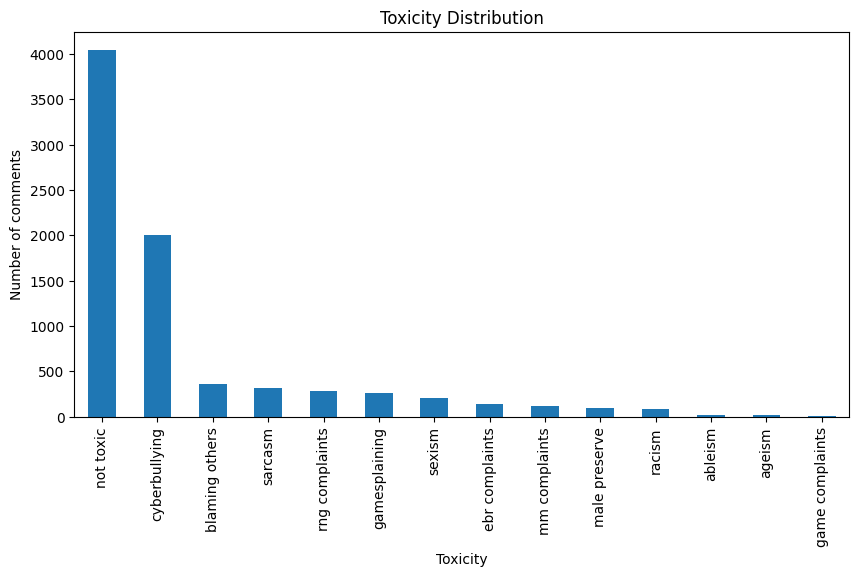

In [14]:
# bar plot 
plt.figure(figsize=(10,5))
df['toxicity'].value_counts().plot(kind='bar')
plt.ylabel('Number of comments')
plt.xlabel('Toxicity')
plt.title('Toxicity Distribution')
plt.show()

`emotion / sentiment`

In [15]:
df['emotion'].value_counts()

emotion
happy       2183
anger       2015
disgust     1409
sad         1081
neutral      991
surprise     253
Name: count, dtype: int64

Test dataset from the survey and real chat

In [16]:
df2 = pd.read_csv('../dataset/revised_Dataset_ChattyTicket_600data.csv')

In [17]:
df2.head()

,username,chat,sentiment,toxicity
0,GT BLACKSHEEP XIE,mb,sad,not toxic
1,GT BLACKSHEEP XIE,mb kj,sad,not toxic
2,GT BLACKSHEEP XIE,wp,happy,not toxic
3,GT BLACKSHEEP XIE,hahahaahaa,happy,not toxic
4,GT BLACKSHEEP XIE,noice HAHAHHAHAHA,happy,not toxic


In [18]:
df2['toxicity']= df2['toxicity'].apply(lambda x: x.lower())

In [19]:
df2['sentiment'].value_counts()

sentiment
anger       192
happy       184
disgust     134
neutral     120
sad         108
surprise     21
Name: count, dtype: int64

In [20]:
df2['sentiment'].value_counts()

sentiment
anger       192
happy       184
disgust     134
neutral     120
sad         108
surprise     21
Name: count, dtype: int64

In [21]:
df2['toxicity'].value_counts()

toxicity
not toxic          406
cyberbullying      143
sarcasm             91
ebr complaints      31
rng complaints      26
blaming others      22
sexism              16
male preserve        7
game complaints      5
ableism              5
gamesplaining        2
mm complaints        2
racism               2
ageism               1
Name: count, dtype: int64

In [22]:
df2[df2['toxicity'] == 'surprise']

,username,chat,sentiment,toxicity


In [23]:
df2['toxicity'].value_counts()

toxicity
not toxic          406
cyberbullying      143
sarcasm             91
ebr complaints      31
rng complaints      26
blaming others      22
sexism              16
male preserve        7
game complaints      5
ableism              5
gamesplaining        2
mm complaints        2
racism               2
ageism               1
Name: count, dtype: int64

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   username   759 non-null    object
 1   chat       759 non-null    object
 2   sentiment  759 non-null    object
 3   toxicity   759 non-null    object
dtypes: object(4)
memory usage: 23.8+ KB


In [25]:
df2.rename(columns={'sentiment': 'emotion'}, inplace=True)

In [26]:
df2['emotion'].value_counts()

emotion
anger       192
happy       184
disgust     134
neutral     120
sad         108
surprise     21
Name: count, dtype: int64

In [27]:
# compute the test set
print("Total Test set",(7932*0.11)+759)

Total Test set 1631.52


Getting the portion data from the big dataset

In [28]:
df = df.sample(frac=1)

In [29]:
from sklearn.model_selection import train_test_split
train, test =  train_test_split(df, test_size=0.11)

In [30]:
train.to_pickle('../dataset/preprocessed_df_train.pkl')

Combining the two datasets

In [31]:
test_ = pd.concat([df2, test])

In [32]:
df2['emotion'].value_counts()

emotion
anger       192
happy       184
disgust     134
neutral     120
sad         108
surprise     21
Name: count, dtype: int64

In [33]:
train['toxicity'].value_counts()

toxicity
not toxic          3591
cyberbullying      1784
blaming others      318
sarcasm             287
rng complaints      251
gamesplaining       224
sexism              179
ebr complaints      132
mm complaints       102
male preserve        80
racism               71
ageism               17
ableism              16
game complaints       7
Name: count, dtype: int64

In [34]:
# check for any null values
print(test_.isnull().sum())

username    0
chat        0
emotion     0
toxicity    0
dtype: int64


In [35]:
# export train set
test_.to_pickle('../dataset/preprocessed_df_test.pkl')

In [36]:
combined_df = pd.concat([train,test_], ignore_index=True)

In [37]:
combined_df.to_pickle('../dataset/preprocessed_df_combined.pkl')

In [38]:
combined_df['toxicity'].value_counts()

toxicity
not toxic          4450
cyberbullying      2144
sarcasm             405
blaming others      379
rng complaints      307
gamesplaining       261
sexism              218
ebr complaints      175
mm complaints       117
male preserve        98
racism               84
ableism              23
ageism               18
game complaints      12
Name: count, dtype: int64

In [47]:
combined_df

,username,chat,emotion,toxicity
0,neverland,nc,neutral,not toxic
1,Hyacinth#6661,'bobo ka (agent name)' 'babae pala kaya pala b...,anger,blaming others
2,Seiji#B0nk,tanginamo wag kana maglaro matulog ka na,disgust,male preserve
3,Liyan #AX1A,Chingchong,anger,racism
4,G2V Yadidss #0413,tanginamo ang bobo mo,disgust,cyberbullying
...,...,...,...,...
8686,TS Monsterific #6969,Why are you palying this game if your this bad,disgust,gamesplaining
8687,Abystigma#TRUTH,bobo,anger,cyberbullying
8688,AXR lampniibarra #RZCT,Tatanga niyo,anger,ebr complaints
8689,edwrd #oms,trashtalking,anger,cyberbullying


In [40]:
train

,username,chat,emotion,toxicity
2717,neverland,nc,neutral,not toxic
6283,Hyacinth#6661,'bobo ka (agent name)' 'babae pala kaya pala b...,anger,blaming others
1331,Seiji#B0nk,tanginamo wag kana maglaro matulog ka na,disgust,male preserve
4036,Liyan #AX1A,Chingchong,anger,racism
970,G2V Yadidss #0413,tanginamo ang bobo mo,disgust,cyberbullying
...,...,...,...,...
3538,PRKN VINCE #Queen,heal,neutral,not toxic
6944,b00tyhub #666,just fcking plant the spike and many more,anger,gamesplaining
643,Jayx,nice g!! ^^ twitch.tv/janniechandesu,happy,not toxic
2072,HS Akane不 #HonoS,nubs,anger,cyberbullying


In [41]:
test_['emotion'].value_counts()

emotion
anger       433
happy       420
disgust     282
sad         239
neutral     214
surprise     44
Name: count, dtype: int64

In [42]:
combined_df['emotion'].value_counts()

emotion
happy       2367
anger       2207
disgust     1543
sad         1189
neutral     1111
surprise     274
Name: count, dtype: int64

In [43]:
combined_df['toxicity'].value_counts()

toxicity
not toxic          4450
cyberbullying      2144
sarcasm             405
blaming others      379
rng complaints      307
gamesplaining       261
sexism              218
ebr complaints      175
mm complaints       117
male preserve        98
racism               84
ableism              23
ageism               18
game complaints      12
Name: count, dtype: int64

In [45]:
from sklearn.preprocessing import OneHotEncoder
encoder_emotion = OneHotEncoder(sparse_output=False)
encoder_toxicity = OneHotEncoder(sparse_output=False)

y_toxicity_combined = encoder_toxicity.fit_transform(combined_df[['toxicity']])
y_emotion_combined = encoder_emotion.fit_transform(combined_df[['emotion']])



[array(['ableism', 'ageism', 'blaming others', 'cyberbullying',
        'ebr complaints', 'game complaints', 'gamesplaining',
        'male preserve', 'mm complaints', 'not toxic', 'racism',
        'rng complaints', 'sarcasm', 'sexism'], dtype=object)]

In [48]:
combined_df

,username,chat,emotion,toxicity
0,neverland,nc,neutral,not toxic
1,Hyacinth#6661,'bobo ka (agent name)' 'babae pala kaya pala b...,anger,blaming others
2,Seiji#B0nk,tanginamo wag kana maglaro matulog ka na,disgust,male preserve
3,Liyan #AX1A,Chingchong,anger,racism
4,G2V Yadidss #0413,tanginamo ang bobo mo,disgust,cyberbullying
...,...,...,...,...
8686,TS Monsterific #6969,Why are you palying this game if your this bad,disgust,gamesplaining
8687,Abystigma#TRUTH,bobo,anger,cyberbullying
8688,AXR lampniibarra #RZCT,Tatanga niyo,anger,ebr complaints
8689,edwrd #oms,trashtalking,anger,cyberbullying
